# nano4M with audio modality

In [1]:
import os
from pathlib import PosixPath


os.environ["CUDA_VISIBLE_DEVICES"]="0"

current_folder = globals()['_dh'][0]
new_path = current_folder.with_name("nano4M")
os.chdir(os.path.abspath(new_path))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from cosmos_tokenizer.image_lib import ImageTokenizer
from encodec import EncodecModel
from IPython.display import Audio
import torch
from nanofm.data.multimodal.simple_multimodal_dataset import SimpleMultimodalDataset
from nanofm.data.multimodal.masking import SimpleMultimodalMasking
from transformers import AutoTokenizer
from tokenizers.processors import TemplateProcessing
import re
import math
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from huggingface_hub import snapshot_download
from cosmos_tokenizer.image_lib import ImageTokenizer
from encodec.utils import convert_audio
import torchaudio
from encodec import EncodecModel
from IPython.display import display, Audio
from nanofm.utils.checkpoint import load_model_from_safetensors

device = 'cuda' if torch.cuda.is_available() else 'cpu'




/work/com-304/new_environment/anaconda3/envs/nanofm/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Configuration Parameters

In [2]:
modalities = ["tok_rgb@256", "caption","tok_audio@48k"]
vocab_sizes = [64000, 50304,1025]
max_seq_lens =  [256, 256,256]
input_alphas =  [1.0, 1.0,1.0]
target_alphas = [1.0, 1.0,1.0]
input_tokens_range =  (1, 128)
target_tokens_range = (1, 128)

In [3]:
TOK_PATH = "/work/com-304/snoupy/nvidia2/Cosmos-0.1-Tokenizer-DI16x16"
# Mask
mask_transform = SimpleMultimodalMasking(
    modalities=modalities,
    vocab_sizes=vocab_sizes,
    max_seq_lens=max_seq_lens,
    input_alphas=input_alphas,
    target_alphas=target_alphas,
    input_tokens_range=input_tokens_range,
    target_tokens_range=target_tokens_range,
    overlap_vocab=True,
    overlap_posembs=True,
    include_unmasked_data_dict=True,
)

# Dataset
dataset = SimpleMultimodalDataset(
    root_dir='/work/com-304/snoupy/audiocaps',
    split='train',
    modalities=modalities,
    sample_from_k_augmentations=10,
    text_tokenizer_path='gpt2',
    text_max_length=256,
    transforms=mask_transform,
)

# Text tokenizer
def get_text_tokenizer(text_tokenizer_path):
        tokenizer = AutoTokenizer.from_pretrained(text_tokenizer_path)
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        tokenizer.add_special_tokens({
            'bos_token': '[SOS]',
            'eos_token': '[EOS]',
        })
        tokenizer._tokenizer.post_processor = TemplateProcessing(
            single="[SOS] $A [EOS]",
            special_tokens=[('[EOS]', tokenizer.eos_token_id), ('[SOS]', tokenizer.bos_token_id)],
        )
        return tokenizer

# Audio tokenizer
def get_audio_tokenizer():
    model = EncodecModel.encodec_model_48khz().to(device)
    model.set_target_bandwidth(6.0)
    return model

# Image tokenizer 

def load_tokenizer():
    """
    Loads nvidia/Cosmos-0.1-Tokenizer-DI16x16 tokenizer
    """
    snapshot_download(
        repo_id="nvidia/Cosmos-0.1-Tokenizer-DI16x16",
        local_dir=TOK_PATH
    )
    return ImageTokenizer(
        checkpoint_enc=f"{TOK_PATH}/encoder.jit",
        checkpoint_dec=f"{TOK_PATH}/decoder.jit",
        device = device
    )

text_tokenizer = get_text_tokenizer("gpt2")
audio_tokenizer = get_audio_tokenizer()
image_tokenizer = load_tokenizer()


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

# Tokenizer reconstruction
## Image

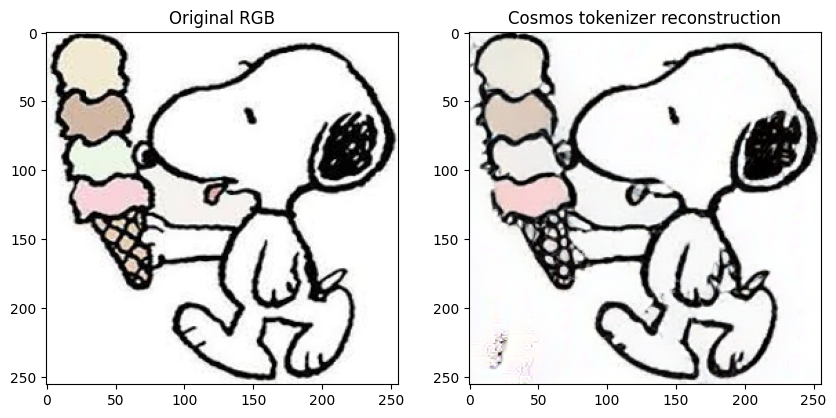

In [4]:
# Test IMG
img = Image.open("../notebooks/assets/snoupy2.jpg").resize((256,256)).convert('RGB')
img_tensor = TF.to_tensor(img).to(device).unsqueeze(0) * 2 - 1
tokens, _ = image_tokenizer.encode(img_tensor)
reconst = image_tokenizer.decode(tokens).float().clamp(-1,1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].imshow(img)
ax[0].set_title('Original RGB')
ax[1].imshow(reconst[0].cpu().permute(1,2,0) / 2 + 0.5)
ax[1].set_title('Cosmos tokenizer reconstruction')
plt.show()



## Audio 

In [5]:
# Test audio
wav,sr = torchaudio.load("../notebooks/assets/original.wav")
wav = convert_audio(wav, sr, audio_tokenizer.sample_rate, audio_tokenizer.channels)
wav = wav.unsqueeze(0).to(device)

# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = audio_tokenizer.encode(wav)
    reconstruction  = audio_tokenizer.decode(encoded_frames)

print("Original")
display(Audio(wav.squeeze(0).detach().cpu(),rate=audio_tokenizer.sample_rate))
print("Reconstruction")
display(Audio(reconstruction.squeeze(0).detach().cpu(),rate=audio_tokenizer.sample_rate))

Original


Reconstruction


# Dataset 

In [6]:
def token_ids_to_image(token_ids, image_tokenizer, to_pil=False):
    n_tokens = token_ids.numel()
    side = int(math.sqrt(n_tokens))
    token_ids = token_ids.reshape(1,side,side).to(device)
    reconst = image_tokenizer.decode(token_ids)
    reconst = (reconst[0].clamp(-1,1).float().cpu() + 1) / 2
    if to_pil:
        reconst = TF.to_pil_image(reconst)
    return reconst
def token_ids_to_audio(tokens):
    encoded = tokens.squeeze(0).reshape((4,-1))
    encoded_list = torch.split(encoded,audio_tokenizer.frame_rate,dim=1)
    enc_frames = []
    for enc in encoded_list:
        enc_frames.append((enc.unsqueeze(0),torch.tensor([[0.1]]).to(device)))
    display(Audio(audio_tokenizer.decode(enc_frames).squeeze(0).detach().cpu(),rate=audio_tokenizer.sample_rate))
            
def get_modality_with_mask(data_dict, mod_name, mask_type=None):
    tokens = data_dict['unmasked_data_dict'][mod_name].clone()
    L = tokens.shape[0]
    if mask_type == 'input':
        modality_mask = data_dict['enc_modalities'] == modalities.index(mod_name)
        modality_mask = modality_mask & data_dict['enc_pad_mask']
        modality_indices = data_dict['enc_positions'][modality_mask]
    elif mask_type == 'target':
        modality_mask = data_dict['dec_modalities'] == modalities.index(mod_name)
        modality_mask = modality_mask & data_dict['dec_pad_mask']
        modality_indices = data_dict['dec_positions'][modality_mask]
    elif mask_type is None:
        modality_indices = torch.arange(L)
    else:
        raise ValueError()
    mask = torch.zeros(L, dtype=torch.bool)
    mask[modality_indices] = True # True = input, False = masked out
    return tokens, mask

def get_masked_image(img, mask):
    mask = mask.reshape(1,1,16,16).float()
    mask = F.interpolate(mask, (256,256), mode='nearest')[0,0].bool()
    img[:,~mask] = 0
    img = img.permute(1,2,0)
    return img

def get_masked_audio(tokens):
    encoded = tokens.reshape((4,-1))
    encoded_list = torch.split(encoded,audio_tokenizer.frame_rate,dim=1)
    enc_frames = []
    for enc in encoded_list:
        enc_frames.append((enc.unsqueeze(0),torch.tensor([[0.1]]).to(device)))
    return audio_tokenizer.decode(enc_frames)
    
    
def plot_data_dict_with_mask(data_dict, mask_type=None):
    # Scene description
    tokens, mask = get_modality_with_mask(data_dict, 'caption', mask_type=mask_type)
    n_scene_desc = mask.sum().item()
    tokens[~mask] = 62 # Simply plot masked out regions as underscores
    print(f'Caption: {dataset.text_tokenizer.decode(tokens)}\n\n')
    
    fig = plt.figure(figsize=(10,4))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.1)
    
    # RGB
    tokens, mask = get_modality_with_mask(data_dict, 'tok_rgb@256', mask_type=mask_type)
    n_rgb = mask.sum().item()
    img = get_masked_image(token_ids_to_image(tokens, image_tokenizer), mask)
    grid[0].imshow(img)
    grid[0].set_title('RGB')
     
    plt.show()
    
    # Audio 
    tokens,mask = get_modality_with_mask(data_dict,'tok_audio@48k',mask_type=mask_type)
    n_audio = mask.sum().item()
    wf = get_masked_audio(tokens).squeeze(0)
    Audio(wf.numpy(), rate=48000)
    
    if mask_type is not None:
        print()
        print(f'Num. scene_desc tokens: {n_scene_desc}')
        print(f'Num. tok_rgb@256 tokens: {n_rgb}')
        print(f'Num. tok_rgb@256 tokens: {n_audio}')
        print('-'*32)
        total_tokens = n_scene_desc + n_rgb + n_audio
        print(f'Total tokens: {total_tokens}')

# Generation

In [7]:
ckpt_path = '../outputs/full_moda/checkpoint-final.safetensors'
model = load_model_from_safetensors(ckpt_path, device=device)
print(f'{model.get_num_params() / 10**6}M parameters')


41.237504M parameters


In [8]:
# Dataset
dataset = SimpleMultimodalDataset(
    root_dir='/work/com-304/snoupy/audiocaps',
    split='eval2',
    modalities=modalities,
    sample_from_k_augmentations=10,
    text_tokenizer_path='gpt2',
    text_max_length=256,
    transforms=None,
)
def construct_input_from_sample(dataset, idx, input_modality):
    input_tensor = dataset[idx][input_modality]
    n_tokens_input = input_tensor.shape[0]
    enc_input_tokens = input_tensor.unsqueeze(0).to(device)
    enc_input_positions = torch.arange(n_tokens_input, device=device).unsqueeze(0)
    enc_input_modalities = modalities.index(input_modality) * torch.ones(1, n_tokens_input, device=device, dtype=torch.long)
    return enc_input_tokens, enc_input_positions, enc_input_modalities

def show_modality(tokens, modality):
    if modality == 'caption':
        print(dataset.text_tokenizer.decode(tokens[0]))
    elif modality == 'tok_rgb@256':
        token_ids_to_image(tokens, image_tokenizer, to_pil=True).show()
    else:
        token_ids_to_audio(tokens)

## Example directe generation
### RGB -> Caption

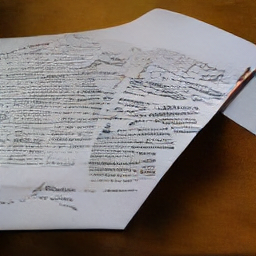

In [9]:
input_modality = 'tok_rgb@256'
sample_idx = 0

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, idx=sample_idx, input_modality=input_modality)
show_modality(x_tokens, input_modality)

In [10]:
target_mod = 'caption'
num_steps, temp, top_p, top_k = 128, 0.7, 0.9, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

[SOS]A man and a[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD

### Caption -> RGB 


In [11]:
input_modality = 'caption'
sample_idx = 0

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, idx=sample_idx, input_modality=input_modality)
show_modality(x_tokens, input_modality)

[SOS]Someone crumples paper[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA

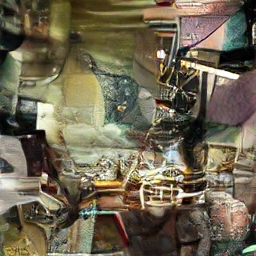

In [12]:
target_mod = 'tok_rgb@256'
num_steps, temp, top_p, top_k = 64, 0.7, 0.9, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

### Text -> Audio

In [13]:
input_modality = 'tok_audio@48k'
sample_idx = 0

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, idx=sample_idx, input_modality=input_modality)
show_modality(x_tokens, input_modality)

In [14]:
target_mod = 'caption'
num_steps, temp, top_p, top_k = 128, 0.7, 0.9, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

[SOS]A man speaking is and chping noises[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

### Audio -> Text 

In [15]:
input_modality = 'caption'
sample_idx = 0

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, idx=sample_idx, input_modality=input_modality)
show_modality(x_tokens, input_modality)

[SOS]Someone crumples paper[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA

In [16]:
target_mod = 'tok_audio@48k'
num_steps, temp, top_p, top_k = 128, 0.7, 0.9, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

### RGB -> Audio

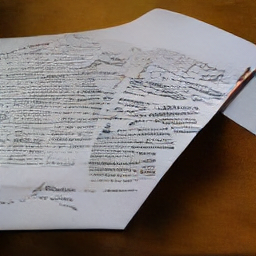

In [17]:
input_modality = 'tok_rgb@256'
sample_idx = 0

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, idx=sample_idx, input_modality=input_modality)
show_modality(x_tokens, input_modality)

In [18]:
target_mod = 'tok_audio@48k'
num_steps, temp, top_p, top_k = 128, 0.7, 0.9, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

### Audio -> RGB

In [19]:
input_modality = 'tok_audio@48k'
sample_idx = 0

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, idx=sample_idx, input_modality=input_modality)
show_modality(x_tokens, input_modality)

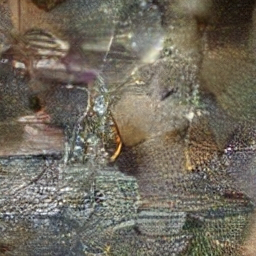

In [20]:
target_mod = 'tok_rgb@256'
num_steps, temp, top_p, top_k = 64, 0.7, 0.9, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

## Problem
### Tokenizer granularity 

In [21]:
wav,sr = torchaudio.load("../notebooks/assets/original.wav")
wav = convert_audio(wav, sr, audio_tokenizer.sample_rate, audio_tokenizer.channels)
wav = wav.unsqueeze(0).to(device)

# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = audio_tokenizer.encode(wav)
    reconstruction  = audio_tokenizer.decode(encoded_frames).squeeze(0)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1).flatten()
print(f"Number of token to represent {wav.shape[2]/sr} s of audio : {codes.shape[0]}")
print(f"Audio with only the first 256 tokens")
crop_wav = reconstruction[:,:256].detach().cpu()
print(crop_wav.shape)
display(Audio(crop_wav,rate = audio_tokenizer.sample_rate))



Number of token to represent 6.0 s of audio : 1212
Audio with only the first 256 tokens
torch.Size([2, 256])


## Ablation on num_steps

[SOS]Someone crumples paper[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA

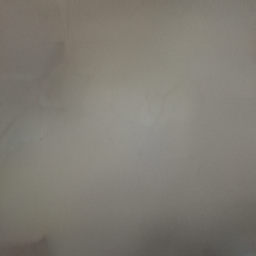

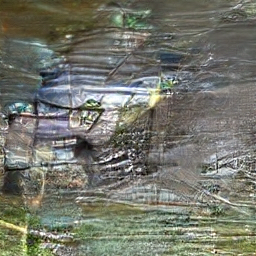

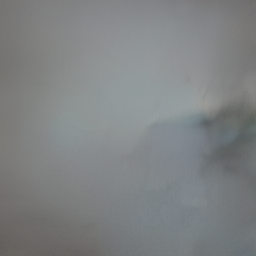

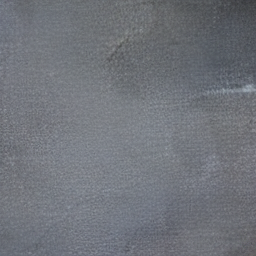

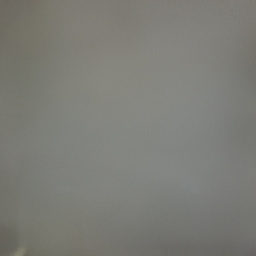

In [ ]:
input_modality = 'caption'
num_steps_ls = [16,32,64,128,256]
temp, top_p, top_k = 0.5, 0.5, 0.0
sample_idx = 0

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, idx=sample_idx, input_modality=input_modality)
print(f"=== Input ===")
show_modality(x_tokens, input_modality)
target_mod = 'tok_rgb@256'

for num_steps in num_steps_ls:
    x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, idx=sample_idx, input_modality=input_modality)
    pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
        x_tokens, x_positions, x_modalities, target_mod=target_mod,
        num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
    )
    print(f"=== {num_steps} ===")
    show_modality(pred_tokens, target_mod)